In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

IF isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. This path length, averaged over a forest of such random trees, is a measure of normality and our decision function. <br>
Random partitioning produces noticeably shorter paths for anomalies.

In [42]:
#Loading the Dataframe
Dataset_std = pd.read_pickle("Data_te_std.pkl")
Dataset_norm = pd.read_pickle("Data_te_norm.pkl") 
Attack_label = pd.read_pickle("Attack_label.pkl")


# Working with smaller Dataset first
from sklearn.utils.random import sample_without_replacement
indices = sample_without_replacement(Dataset_std.shape[0], Dataset_std.shape[0]/8, random_state=22)
Dataset_std_short = pd.DataFrame(Dataset_std.loc[indices.tolist()])
Dataset_norm_short = pd.DataFrame(Dataset_norm.loc[indices.tolist()])
Attack_label_short = pd.DataFrame(Attack_label.loc[indices.tolist()])


# Checking distribution before and after shortening
print("Original Dataset Shape: ", Dataset_std.shape)
print("Reduced Dataset Shape: ", Dataset_std_short.shape)

Original Dataset Shape:  (157800, 36)
Reduced Dataset Shape:  (19725, 36)


In [55]:
# seperating Datasamples with normal and abnormal samples
Dataset_only0 = Dataset_norm_short.loc[Attack_label_short['Attack_label'] == 0] # normal label
Dataset_only1 = Dataset_norm_short.loc[Attack_label_short['Attack_label'] == 1] 
print("Sample shape of only normal label", Dataset_only0.shape)
print("Sample shape of only abnormal label", Dataset_only1.shape)

Sample shape of only normal label (3000, 36)
Sample shape of only abnormal label (16725, 36)


In [56]:
from sklearn.model_selection import train_test_split
array_train_0, array_test_0 = train_test_split(Dataset_only0, train_size=0.8, random_state=22)
array_train_1, array_test_1 = train_test_split(Dataset_only1, train_size=0.025, random_state=22)
print("array_train_0 shape: ", array_train_0.shape, "\narray_train_1 shape: ", array_train_1.shape)

X_train = pd.concat([array_train_0, array_train_1])
Y_train = pd.concat([pd.DataFrame([1]*array_train_0.shape[0]), pd.DataFrame([-1]*array_train_1.shape[0])])
X_test = pd.concat([array_test_0, array_test_1])
Y_test = pd.concat([pd.DataFrame([1]*array_test_0.shape[0]), pd.DataFrame([-1]*array_test_1.shape[0])]) 

array_train_0 shape:  (2400, 36) 
array_train_1 shape:  (418, 36)


## Sampling

In [33]:
from imblearn.combine import SMOTEENN
sm = SMOTEENN(random_state= 22)
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
print("Target Shape: ", Y_train.shape)
print("Resampled Target Shape: ", Y_train_res.shape)

Target Shape:  (3236, 1)
Resampled Target Shape:  (3466, 1)


## Hyperparameter

In [62]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': ['auto', 0.5, 0.75],
    'contamination': [0.1, 0.2],
    'max_features': [1.0, 0.5],
    'bootstrap': [False, True]
}
from sklearn.metrics import make_scorer, roc_auc_score, f1_score

def custom_scorer(y_true, y_pred):
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    return f1_score(y_true, y_pred)

scorer = make_scorer(custom_scorer, greater_is_better=True)

isolation_forest = IsolationForest(random_state=42)

grid_search = GridSearchCV(
    estimator=isolation_forest,
    param_grid=param_grid,
    scoring= scorer,  # You may need to define a custom scoring function for outlier detection
    cv=3,               # Use 3-fold cross-validation
    n_jobs=-1,          # Use all processors
    verbose=1
)

grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best ROC AUC Score: {best_score}")
print(f"Best Parameters: {best_params}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/home/user/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/user/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/user/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/user/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/tmp/ipykernel_2326616/155841818.py", line 15, in custom_scorer
  File "/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    re

Best ROC AUC Score: nan
Best Parameters: {'bootstrap': False, 'contamination': 0.1, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 50}


/home/user/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/user/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/user/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/user/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/tmp/ipykernel_2326616/155841818.py", line 15, in custom_scorer
  File "/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    re

## The modal

In [59]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, random_state=22, max_features= 35,
                       contamination=array_train_1.shape[0]/(X_train.shape[0]))
clf.fit(X_train)
Y_pred = clf.predict(X_test)

In [62]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_PCA = pca.fit_transform(X_train)
X_PCA_test = pca.transform(X_test)
clf = IsolationForest(random_state=22, max_features= 10,
                       contamination=array_train_1.shape[0]/(X_train.shape[0]))
clf.fit(X_PCA)
Y_pred = clf.predict(X_PCA_test)

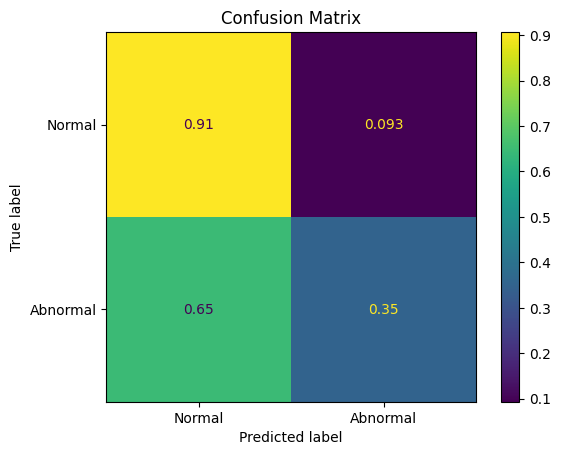

Average Accuracy Score: 0.3713254864848879
Balanced Accuracy Score: 0.6291474009116739
         Precision    Recall  F1-Score
Anomaly   0.990328  0.351628  0.518984


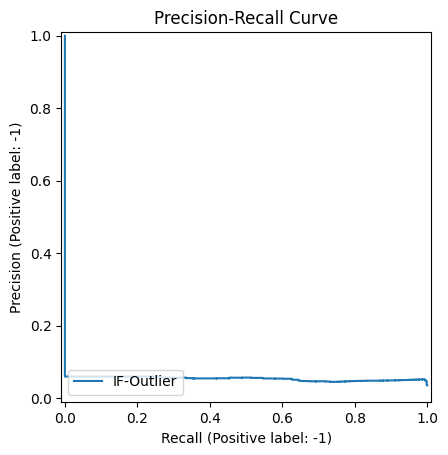

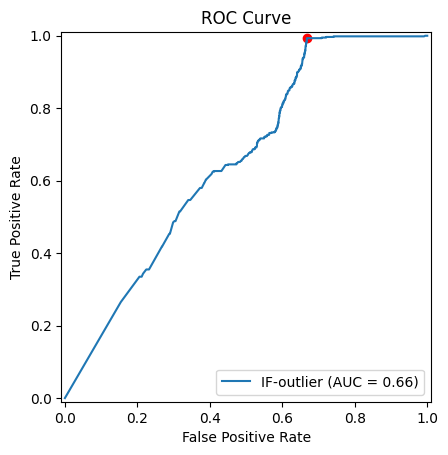

In [63]:
import numpy as np
from sklearn import metrics

cm = metrics.confusion_matrix(Y_test, Y_pred, normalize= 'true', labels=[1, -1])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix')   
plt.show()

print("Average Accuracy Score:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
print("Balanced Accuracy Score:",metrics.balanced_accuracy_score(Y_test, Y_pred)) # balanced Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'Recall': metrics.recall_score(Y_test, Y_pred, pos_label= -1,labels=[-1], average = 'binary'),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, pos_label= -1, labels=[-1], average = 'binary')},
                        index=['Anomaly'])
                        
print(df_metric)

# FOR Prec-Recall and ROC, decision function scores are needed (not just -1 or 1 labels)
Y_scores = clf.decision_function(X_PCA_test)

#Precision-Recall Curve
prec, recall, thresh = metrics.precision_recall_curve(Y_test, Y_scores)
pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall, pos_label= -1, estimator_name='IF-Outlier').plot()
plt.title('Precision-Recall Curve')

# ROC Curve
fpr, tpr, thresh = metrics.roc_curve(Y_test, Y_scores)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='IF-outlier')

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
roc_display.plot()
plt.scatter(best_fpr, best_tpr, c = 'red')
plt.title("ROC Curve")
plt.show()